# Week 8 - Semantic & Influence Networks

This week, we explore the representation and analysis of semantic networks. A word or document network is an unsupervized representation of text akin to a clustering or an embedding, but semantic networks can also be defined using semantic or syntactic information derived from methods we have used earlier in the quarter. For example, we can define links between words as a function of their co-presence within a document, chapter, paragraph, sentence, noun phrase or continuous bag of words. We can also define links as a function of words that rely on one another within a directed dependency parse, or links between extracted Subjects, Verbs and Objects, or nouns and the adjectives that modify them (or verbs and the adverbs that modify *them*). Rendering words linked as a network or discrete topology allows us to take advantage of the wide range of metrics and models developed for network analysis. These include measurement of network centrality, density and modularity, "block modeling" structurally equivalent relationships, andsophisticated graphical renderings of networks or network partitions that allow us to visually interrogate their structure and complexity.

For this notebook we will use the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import nltk #For POS tagging
import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats

import pickle #if you want to save layouts
import os

%matplotlib inline

# An Introduction to networks in *networkx*

We will primarily be dealing with graphs in this notebook, so lets first go over how to use them.

To start with lets create an undirected graph:

In [2]:
g = nx.Graph()
g

We can add nodes. These are all named, like entries in a dictionary.

In [3]:
g.add_node(1)
g.add_node(2)
g.add_node(3)

Now we have 3 vertices:

In [4]:
len(g.nodes)

3

Or if we want to get more information about the graph:

In [5]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 0
Average degree:   0.0000


We can give nodes properties, like name or type

In [6]:
g.nodes[1]

{}

In [7]:
g.nodes[1]['type'] = 'NN'

In [8]:
g.nodes[1]

{'type': 'NN'}

In [9]:
g.nodes[2]['name'] = 'dog'

In [10]:
g.nodes[2]

{'name': 'dog'}

Still pretty boring...

Lets add a couple of edges. Notice that we use the ids, but not any of the properties:

In [11]:
g.add_edges_from([(1, 2), (2, 3), (3, 1), (1,4)])
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 4
Number of edges: 4
Average degree:   2.0000


Note how the summary has changed. Moreover, there's one additional node, because we asked for an edge to 4.

We can also give the edges properties like weights:

In [12]:
g.edges[1, 2]['weight'] = 2
g.edges[1, 4]['weight'] = 2
g.edges[1, 4]

{'weight': 2}

Let's visualize our graph now:

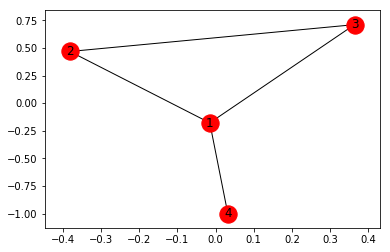

In [13]:
nx.draw_networkx(g)
plt.savefig("test.png")

Very exciting :-).

There are many things to do with the graph once we have created it, some of which we will explore here.

First let's load some data, like the Grimmer Senate press releases corpus:

In [14]:
senReleasesDF = pandas.read_csv('../data/senReleasesTraining.csv', index_col = 0)
senReleasesDF[:3]

download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   

                                            html_url                    name  \
0  https://github.com/lintool/GrimmerSenatePressR...  01Apr2005Kennedy14.txt   
1  https://github.com/lintool/GrimmerSenatePressR...  01Aug2005Kennedy12.txt   
2  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy10.txt   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   

                                                text targetSenator  
0           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
1           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
2           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy

We will be extracting sentences, as well as tokenizing and stemming. (You should be able to do this in your sleep now).

In [15]:
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic) for s in x])

Let's begin by looking at words that co-occur in the same sentences:

In [9]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

First, build a graph based on word cooccurences in the first 100 press releases.

In [17]:
g = wordCooccurrence(senReleasesDF['normalized_sents'][:100].sum())

Total number of vertices:

In [18]:
len(g.nodes)

4270

Total number of edges:

In [19]:
len(g.edges)

2082420

A part of the adjacency matrix of cleaned word by press releases:

In [20]:
nx.to_numpy_matrix(g)[:5, :5]

matrix([[ 4.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.],
        [ 0.,  1., 28.,  0.,  0.],
        [ 0.,  0.,  0.,  6.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]])

We can save the graph and read it later, although this is slow if there are many edges or nodes, so we will filter first, as we will demonstrate below.

In [ ]:
#nx.write_graphml(g, '../data/Obama_words.graphml')

Alternatively, we can build graphs starting with a two-mode network. Let's again use the document-word frequency matrix that we used in week 3.

In [13]:
def tokenize(text):
    tokenlist = nltk.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic)
    return normalized

In [22]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(senReleasesDF['text'][:100])

In [23]:
senVects_incidence.shape

(100, 4270)

We need to turn the incidence matrix into a network. Note the use of bipartite as an attribute--this is how you need to tell networkx the graph is bipartite:

In [24]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [25]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 4370
Number of edges: 22325
Average degree:  10.2174


A very popular layout algorithm for visualizing graphs is the Fruchterman-Reingold Algorithm (or spring layout), which uses a physical metaphor for lay-out. Nodes repel one another, and edges draw connected elements together like springs. The algorithm attempts to minimize the energy in such a system. For a large graph, however, the algorithm is computational demanding. 

Let's plot the bipartite network with a quick spring layout:

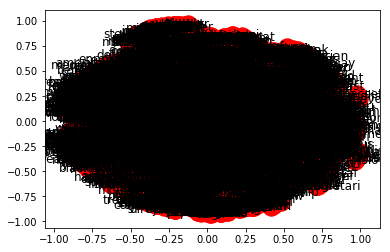

In [26]:
nx.draw_networkx(g_2mode)

With no filtering, this will not bring insight (see below). If we want even faster computation and tunable visualizations, check out [Pajek](http://mrvar.fdv.uni-lj.si/pajek/) or [gephi](https://gephi.org/).

A two-mode network can be easily transformed into two one-mode network, enabling words to be connected to other words via the number of documents that share them, or documents to be connected to other documents via the words they share:

In [8]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [28]:
gDoc = contractNetwork(g_2mode, 'doc')

Let's first take a look at the document-to-document network:

In [29]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 4950
Average degree:  99.0000


Let's construct a visualization. It is not surprising that almost every document is connected to every other. We can use edge weight to distinguish document distance (modeled as attraction):

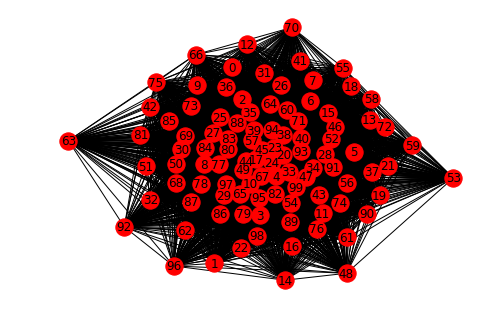

In [30]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

Lets draw the graph with high and low weight edges distinguished:

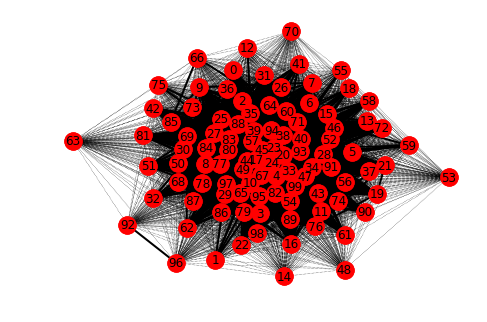

In [31]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

Now we can see why 53 and 63 are on the outside, while 39 and 23 are at the center. We can look at them:

In [32]:
print(len(senReleasesDF.iloc[63]['text']),"words:","\n",senReleasesDF.iloc[63]['text'].strip().replace('  ', '\n'))

314 words: 
 FOR IMMEDIATE RELEASE

Senator Kennedy issued the following statement this evening following Senator Kerrys apology

John Kerry s statement says it all
I wish the Bush administration brought as much energy and focus to trying to correct their mistakes in Iraq as it did in going after John Kerry


In [33]:
print(len(senReleasesDF.iloc[23]['text']),"words:","\n",senReleasesDF.iloc[23]['text'].strip().replace('  ', '\n'))

20603 words: 
 FOR IMMEDIATE RELEASE
REID

 We re sorry that we re starting a little bit late
but the House has some votes going
and so Leader Pelosi will be here and Congresswoman Solis real soon

 I m reminded of the story I learned as a little boy
When the kid was watching the sheep and he was supposed to yell
Wolf
when the wolf was coming
And he yelled
Wolf
as we know

Wolf
Wolf
and there was never any wolf
And finally when a wolf showed up
no one came

 And no matter how hard we try to be bipartisan here in Washington
with President Bush it s the proverbial cry for wolf

 As I said leaving the chamber last night
whatever he says
it s just the opposite

 And we re here today to talk about health care
But the cry of wolf is once again ringing in my ears because he keeps talking about how he wants to improve health care and we re now five years into this and there s been no improvement

 In fact
I hope the president mentions when he s in Tennessee today that there s almost a million 

Ah...those documents with the **most** words are unsprisingly the most central in this simple document network.

Now let's turn it around and look at the word-to-word network by documents. 

In [34]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 4270
Number of edges: 2080405
Average degree: 974.4286


First, let's reduce the number of words to a manageable size.

In [35]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.9883402510568855

We are going to return to the sentence cooccurence graph, as it suggests many more meaningful (more local) associations. But without filtering, it is too large. Let's first drop all the edges with weight below 1250, then drop all the isolates:

In [36]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 1250])
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first
giant = max(nx.connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 166
Number of edges: 496
Average degree:   5.9759


A bit smaller now, Now, let's visualize it: 

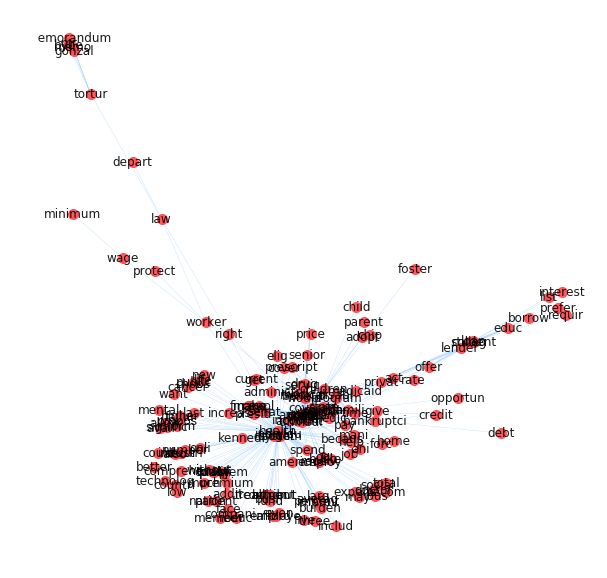

In [37]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We can also remove those words that show up in many documents...those with many connections (note that this has a similar effect to selecting those with a high tf.idf score):

In [38]:
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 166
Number of edges: 496
Average degree:   5.9759


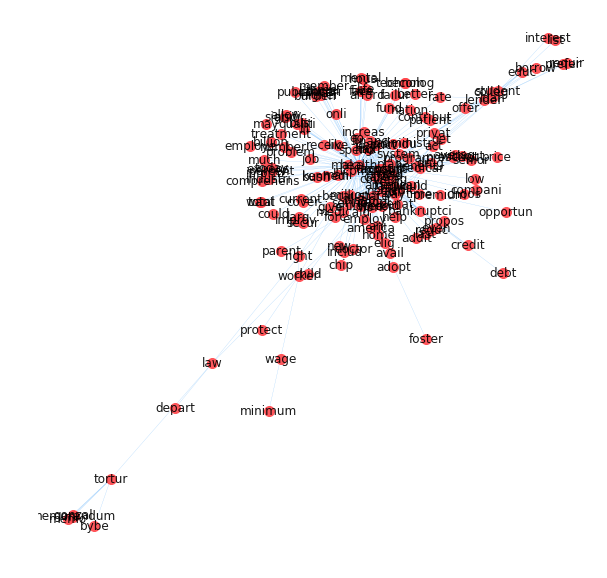

In [39]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We can continue to trim globally to investigate the structure of words at alternative slices of network density. 

Moreover, we can find cliques, or completely connected sets of nodes. 

In [40]:
nx.clique.number_of_cliques(giant)['presid']

2

In [41]:
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

health, care, cost, plan, year, insur, save, provid, american, uninsur, account


Now lets look at a subgraph of the network, those nodes that are within 1 or 2 network steps of 'america'. 

In [42]:
americanNeighbors = giant.neighbors('american')
g_american = giant.subgraph(americanNeighbors)
print(nx.info(g_american))

Name: 
Type: SubGraph
Number of nodes: 22
Number of edges: 154
Average degree:  14.0000


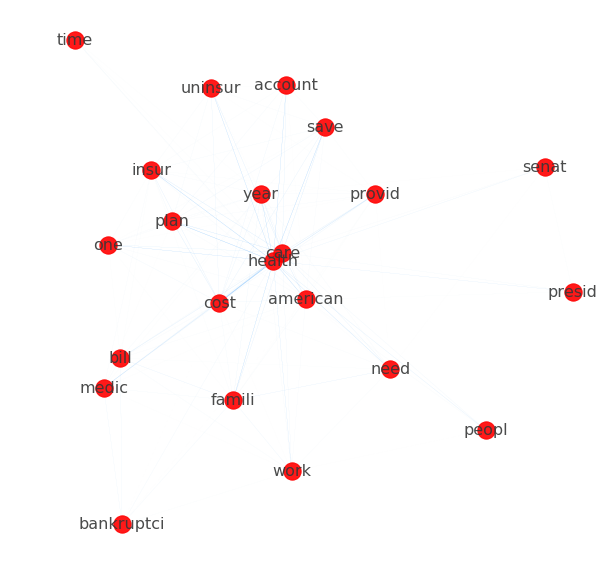

In [43]:
layout_amer = nx.spring_layout(g_american, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_american.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american.edges(data = True)))
nx.draw(g_american, ax = ax, pos = layout_amer, labels = {n:n for n in g_american.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

In [44]:
americanNeighbors = gWord.neighbors('american')
americanNeighborsPlus1 = set(americanNeighbors)
for n in americanNeighbors:
    americanNeighborsPlus1 |= set(giant.neighbors(n))
    
#for x in americanNeighborsPlus1:
#    print(x)

In [45]:
g_american2 = giant.subgraph(americanNeighborsPlus1)
print(nx.info(g_american2))

Name: 
Type: SubGraph
Number of nodes: 165
Number of edges: 474
Average degree:   5.7455


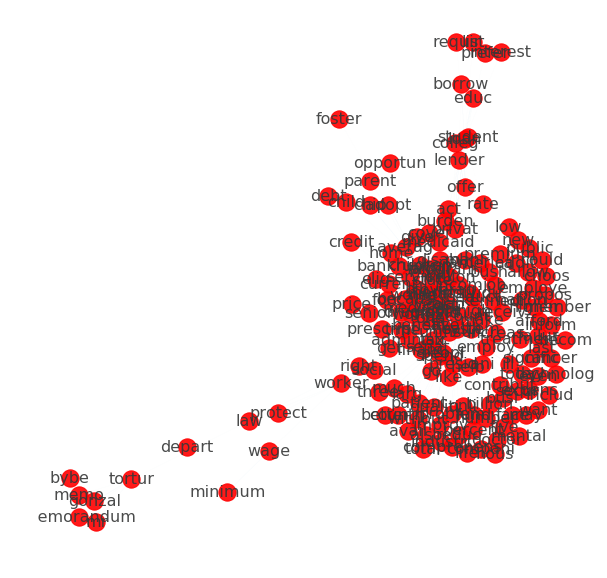

In [46]:
layout_amer = nx.spring_layout(g_american2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_amer = nx.eigenvector_centrality(g_american2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
nx.draw(g_american2, ax = ax, pos = layout_amer, labels = {n:n for n in g_american2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that render some reasonable networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that given insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

<span style="color:blue"> My final project would use transcripts of several soap operas, so the contents of my corpus would be transcripts. As I tried, this corpus is not suitable for document to document network analysis. So in this assignment, I'd use my personal corpus, Wikipedia webpages of music genres, to do this assignment. Since each document represent Wikipedia description of one music genre, the research question I'm aking here is: what are the relationships aming those music genres? Which ones are close, while which ones are not?

In [6]:
# Read in the data
df = pandas.read_csv('wiki_music.csv')

# Tokenize and normalize
df['tokenized_sents'] = df['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
df['normalized_sents'] = df['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic) for s in x])

In [11]:
# Check the network of the first 100 documents, since the entire corpus has too many documents,
# making it to slow to run for this assignment
music_g = wordCooccurrence(df['normalized_sents'][:100].sum())

In [14]:
# Fit model
musicVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
musicVects_incidence = musicVectorizer.fit_transform(df['text'][:100])

music_g_2mode = nx.Graph()

#define all the nodes
music_g_2mode.add_nodes_from((musicVectorizer.get_feature_names()[i] for i in range(musicVects_incidence.shape[1])), bipartite = 'word')
music_g_2mode.add_nodes_from(range(musicVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
music_g_2mode.add_edges_from(((d2, musicVectorizer.get_feature_names()[w], {'weight' : musicVects_incidence[d2, w]}) for d2, w in zip(*musicVects_incidence.nonzero())))

print(nx.info(music_g_2mode))

Name: 
Type: Graph
Number of nodes: 11222
Number of edges: 37172
Average degree:   6.6248


In [15]:
# There's an error in the pre-defined function, so I revise it
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

### Docuemnt to Document Network

In [16]:
music_gDoc = contractNetwork(music_g_2mode, 'doc')
print(nx.info(music_gDoc))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 4892
Average degree:  97.8400


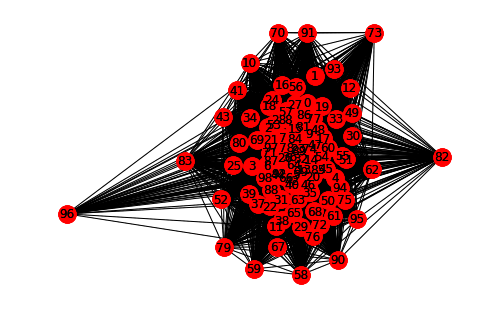

In [17]:
# Plot network
music_layout = nx.spring_layout(music_gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(music_gDoc, pos = music_layout, labels = {n:n for n in music_gDoc.nodes()})
# Plot
wMedian = np.median([d['weight'] for n1, n2, d in music_gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in music_gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in music_gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(music_gDoc, pos = music_layout, labels = {n:n for n in music_gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(music_gDoc, pos = music_layout, nodelist=None, edgelist = edgesHigh, width=2)

In [158]:
print(len(df.iloc[96]['text']),"words:","\n",df.iloc[96]['text'].strip().replace('  ', '\n'))

44 words: 
 Other reasons this message may be displayed:


In [159]:
print(len(df.iloc[97]['text']),"words:","\n",df.iloc[97]['text'].strip().replace('  ', '\n'))

8849 words: 
 Krautrock (also called "kosmische Musik", German: "cosmic music") is a broad genre of experimental rock that developed in Germany in the late 1960s. The term "krautrock" was originated by English-speaking music journalists as a humorous name for a diverse range of German bands whose music drew from sources such as psychedelic rock, the avant-garde, electronic music, funk, minimalism, jazz improvisation, and world music styles.Largely divorced from the traditional blues and rock and roll influences of British and American rock music up to that time, the period contributed to the evolution of electronic music and ambient music as well as the birth of post-punk, alternative rock and New Age music. Important acts of the scene include Can, Kraftwerk, Neu!, Amon Düül II, Ash Ra Tempel, Tangerine Dream, Popol Vuh, and Faust.Until around 1973, the word "Deutsch-Rock" ("German Rock") was used to refer to the new groups from West Germany. "Krautrock" was originally a humorous term 

### Word to Word Network

In [19]:
music_g = wordCooccurrence(df['normalized_sents'][:100].sum())
music_g.remove_edges_from([(n1, n2) for n1, n2, d in music_g.edges(data = True) if d['weight'] <= 500])
music_g.remove_nodes_from(list(nx.isolates(music_g)))
music_giant = max(nx.connected_component_subgraphs(music_g), key=len)
print(nx.info(music_giant))

Name: 
Type: Graph
Number of nodes: 2
Number of edges: 3
Average degree:   3.0000


In [20]:
music_g = wordCooccurrence(df['normalized_sents'][:100].sum())
music_g.remove_edges_from([(n1, n2) for n1, n2, d in music_g.edges(data = True) if d['weight'] <= 100])
music_g.remove_nodes_from(list(nx.isolates(music_g)))
music_giant = max(nx.connected_component_subgraphs(music_g), key=len)
print(nx.info(music_giant))

Name: 
Type: Graph
Number of nodes: 64
Number of edges: 100
Average degree:   3.1250


In [22]:
music_g = wordCooccurrence(df['normalized_sents'][:100].sum())
music_g.remove_edges_from([(n1, n2) for n1, n2, d in music_g.edges(data = True) if d['weight'] <= 75])
music_g.remove_nodes_from(list(nx.isolates(music_g)))
music_giant = max(nx.connected_component_subgraphs(music_g), key=len) 
print(nx.info(music_giant))

Name: 
Type: Graph
Number of nodes: 96
Number of edges: 166
Average degree:   3.4583


In [24]:
music_g = wordCooccurrence(df['normalized_sents'][:100].sum())
music_g.remove_edges_from([(n1, n2) for n1, n2, d in music_g.edges(data = True) if d['weight'] <= 50])
music_g.remove_nodes_from(list(nx.isolates(music_g)))
music_giant = max(nx.connected_component_subgraphs(music_g), key=len)
print(nx.info(music_giant))

Name: 
Type: Graph
Number of nodes: 166
Number of edges: 349
Average degree:   4.2048


In [23]:
music_g = wordCooccurrence(df['normalized_sents'][:100].sum())
music_g.remove_edges_from([(n1, n2) for n1, n2, d in music_g.edges(data = True) if d['weight'] <= 30])
music_g.remove_nodes_from(list(nx.isolates(music_g)))
music_giant = max(nx.connected_component_subgraphs(music_g), key=len)
print(nx.info(music_giant))

Name: 
Type: Graph
Number of nodes: 308
Number of edges: 862
Average degree:   5.5974


In [21]:
music_g = wordCooccurrence(df['normalized_sents'][:100].sum())
music_g.remove_edges_from([(n1, n2) for n1, n2, d in music_g.edges(data = True) if d['weight'] <= 10])
music_g.remove_nodes_from(list(nx.isolates(music_g)))
music_giant = max(nx.connected_component_subgraphs(music_g), key=len)
print(nx.info(music_giant))

Name: 
Type: Graph
Number of nodes: 1095
Number of edges: 5805
Average degree:  10.6027


<span style='color:blue'> To make the network reasonable and easy to visualize, I choose to discard the edges whose weight is less than 50

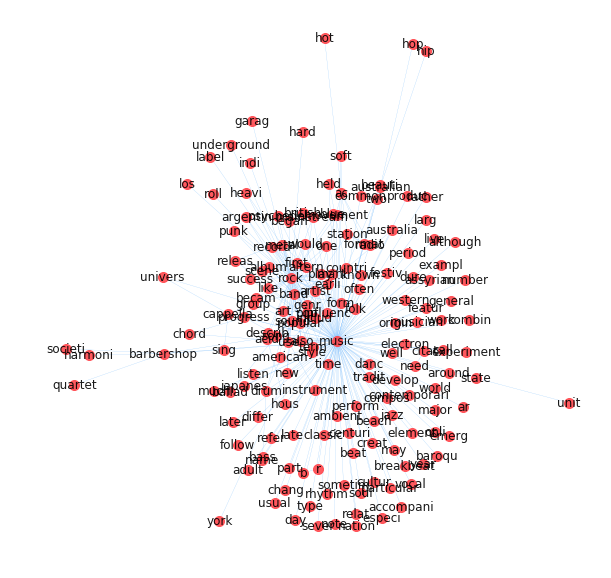

In [25]:
# Plot
layout = nx.spring_layout(music_giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(music_giant, ax = ax, pos = layout, labels = {n:n for n in music_giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue')

In [26]:
print(', '.join(max(nx.clique.find_cliques(music_giant), key = lambda x: len(x))))

music, rock, band, use, also, includ


Name: 
Type: SubGraph
Number of nodes: 57
Number of edges: 186
Average degree:   6.5263


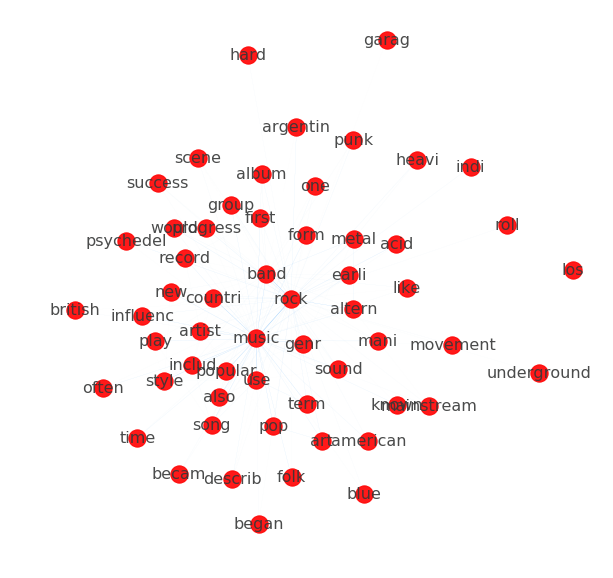

In [161]:
rockNeighbors = music_giant.neighbors('rock')
g_rock = music_giant.subgraph(rockNeighbors)
print(nx.info(g_rock))

layout_rock = nx.spring_layout(g_rock, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_rock.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_rock.edges(data = True)))
nx.draw(g_rock, ax = ax, pos = layout_rock, labels = {n:n for n in g_rock.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_rock.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

In [29]:
# Generate word to word network
music_gWord = contractNetwork(music_g_2mode, 'word')

Name: 
Type: SubGraph
Number of nodes: 165
Number of edges: 292
Average degree:   3.5394


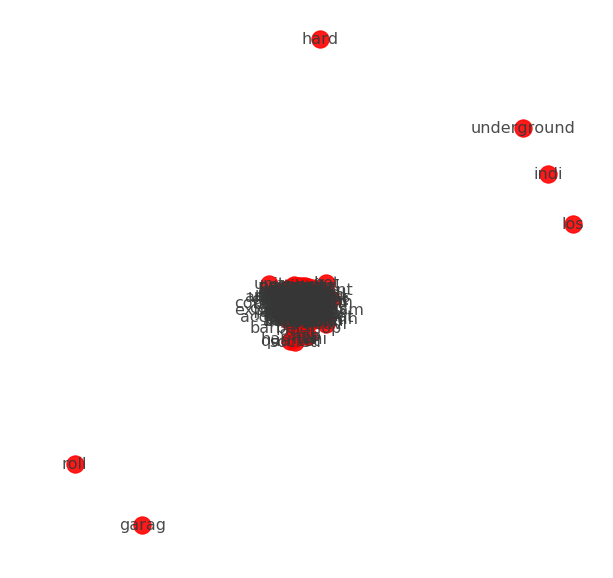

In [30]:
rockNeighbors = music_gWord.neighbors('rock')
rockNeighborsPlus1 = set(rockNeighbors)
for n in rockNeighbors:
    rockNeighborsPlus1 |= set(music_giant.neighbors(n))
#
g_rock2 = music_giant.subgraph(rockNeighborsPlus1)
print(nx.info(g_rock2))
# Plot
layout_rock = nx.spring_layout(g_rock2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_rock = nx.eigenvector_centrality(g_rock2)
maxC = max(centralities_rock.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_rock2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_rock2.edges(data = True)))
nx.draw(g_rock2, ax = ax, pos = layout_rock, labels = {n:n for n in g_rock2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_rock2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

<span style='color:blue'> Document to document networks. In this assignment, I try to look at network among 100 documents describing different music genres. The results tell me, for example, that Document 96 are very far from the other documents, while the Document 97 are the center of the network. As I check the contents of the documents, Document 96 is extremely short, which doesn't contain frequently used words in description of music genres. And Document 97 is very long, containing many words frequently used in descriptin of music genres. So documents that is long and that contains many frequently used words in corresponding domain would be likely to be at the center.

<span style="color:blue"> Word to word networks. As I tried above, the optimal threshold is edges with weights = 50. Withi this setting, I coule get a network with 166 nodes and 349 edges, which is neigher too large to discard too many useful information nor too small to make the network hard to visualize. And the suitable filters could be names of music genres, for example, 'rock'. When I use 'rock' to filter the network, I get a network with the words 'punk', 'folk', and 'blue' connected with 'rock'. It tells me that punk music, folk music, blues music are connected with rock music. But there's no 'pop' or 'classic', which tells me that pop music or classical music might not be connected with rock music.

# Network Statistics
We can often gain more insight into our semantic network through statistics that describe the positions of words within it.

We begin with measures of centrality. The concept of centrality is that some nodes (words or documents) are more *central* to the network than others. The most straightforward is the notion of degree centrality: those nodes that have the highest number of connections are the most central. Here our measure normalizes the number of connections by those with the most connections.

In [47]:
dcentralities = nx.degree_centrality(giant)

In [48]:
dcentralities['senat']

0.048484848484848485

In [49]:
max(dcentralities.items(), key = lambda x : x[1])

('health', 0.8242424242424242)

We can color and size the nodes by betweenness centrality, it's much faster to redraw since we aren't redoing the layout.

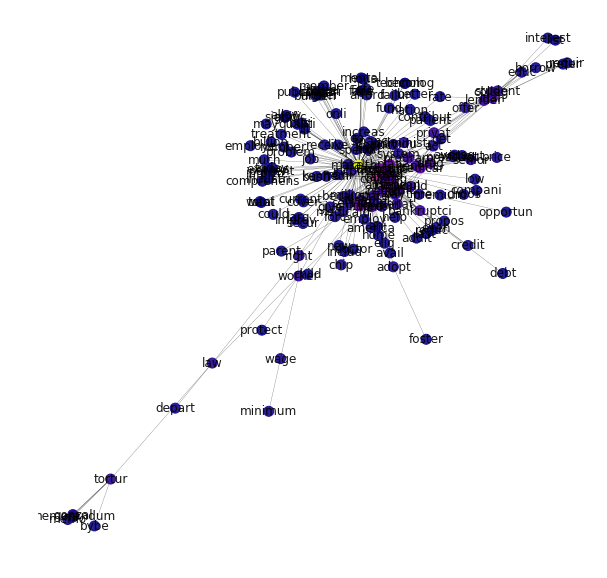

In [50]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Another way to visualize the graph involes the use of size to represent degree centrality and edge weight:

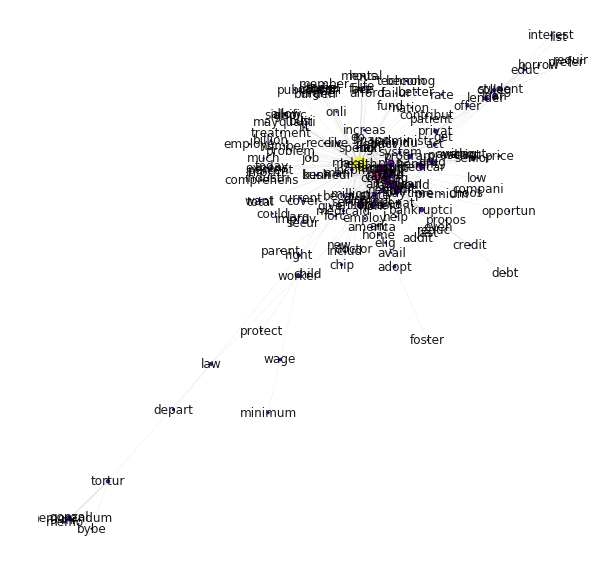

In [51]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of degree centrality is:

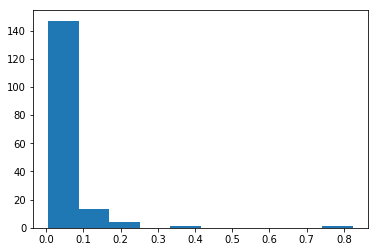

In [52]:
plt.hist(list(dcentralities.values()))
plt.show()

What are the top and bottom ten words in terms of degree?

In [53]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.8242424242424242),
 ('care', 0.36363636363636365),
 ('cost', 0.23636363636363636),
 ('famili', 0.19393939393939394),
 ('children', 0.17575757575757575),
 ('year', 0.1696969696969697),
 ('plan', 0.15757575757575756),
 ('american', 0.1393939393939394),
 ('medicar', 0.1393939393939394),
 ('bill', 0.13333333333333333)]

In [54]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('social', 0.006060606060606061),
 ('even', 0.006060606060606061),
 ('failur', 0.006060606060606061),
 ('today', 0.006060606060606061),
 ('addit', 0.006060606060606061),
 ('expens', 0.006060606060606061),
 ('child', 0.006060606060606061),
 ('secur', 0.006060606060606061),
 ('could', 0.006060606060606061),
 ('also', 0.006060606060606061)]

Consider another very different measure, which is *betweenness* centrality. Betweenness centrality distinguishes nodes that require the most shortest pathways between all other nodes in the network. Semantically, words with a high betweenness centrality may link distinctive domains, rather than being "central" to any one. In other words, high *betweenness centrality* nodes may not have the highest *degree centrality*.

In [55]:
centralities = nx.betweenness.betweenness_centrality(giant)

In [56]:
centralities['senat']

3.695491500369549e-05

In [57]:
max(centralities.items(), key = lambda x : x[1])

('health', 0.7974546258832459)

We can color and size the nodes by betweenness centrality:

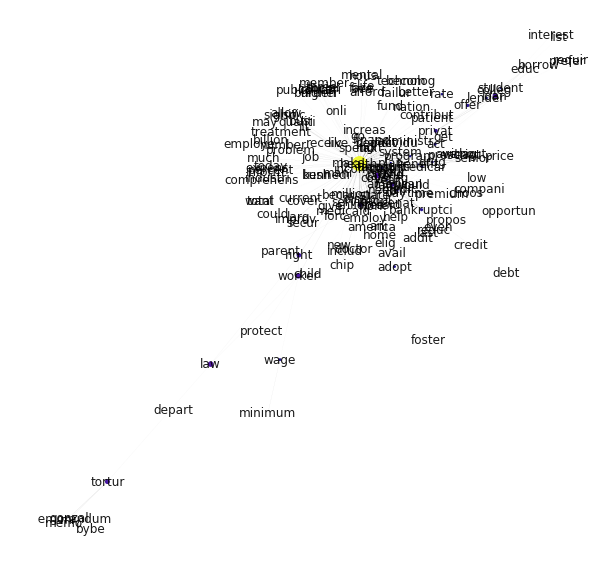

In [58]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of betweenness centrality is:

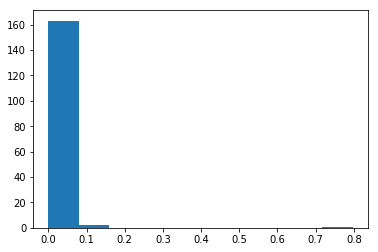

In [59]:
plt.hist(list(centralities.values()))
plt.show()

This is an exponential distrubution, but you might need to add more nodes to see it clearly.

What are the top ten words in terms of betweenness?

In [60]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.8242424242424242),
 ('care', 0.36363636363636365),
 ('cost', 0.23636363636363636),
 ('famili', 0.19393939393939394),
 ('children', 0.17575757575757575),
 ('year', 0.1696969696969697),
 ('plan', 0.15757575757575756),
 ('american', 0.1393939393939394),
 ('medicar', 0.1393939393939394),
 ('bill', 0.13333333333333333)]

What are words lower down?

In [61]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[50:60]

[('mr', 0.024242424242424242),
 ('servic', 0.024242424242424242),
 ('high', 0.024242424242424242),
 ('deduct', 0.024242424242424242),
 ('system', 0.024242424242424242),
 ('wage', 0.024242424242424242),
 ('individu', 0.024242424242424242),
 ('prescript', 0.024242424242424242),
 ('spend', 0.01818181818181818),
 ('becaus', 0.01818181818181818)]

We can also look at closeness centrality, or the average Euclidean or path distance between a node and all others in the network. A node with the highest closeness centrality is most likely to send a signal with the most coverage to the rest of the network.

In [62]:
centralities = nx.closeness_centrality(giant)

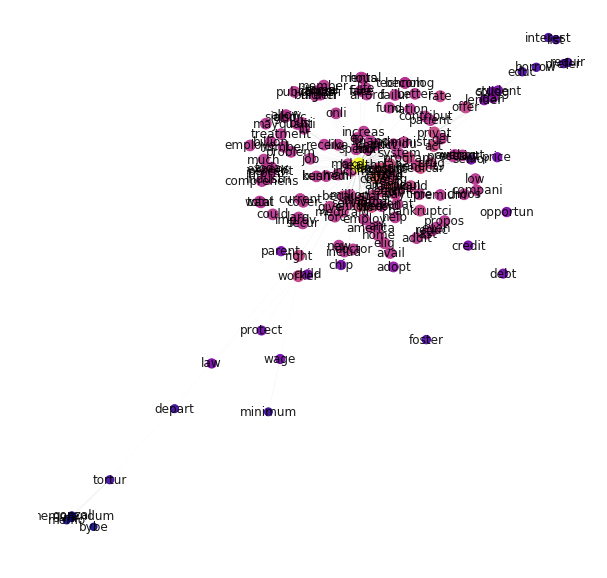

In [63]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Top and bottom:

In [64]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.7638888888888888),
 ('care', 0.559322033898305),
 ('cost', 0.5092592592592593),
 ('famili', 0.5045871559633027),
 ('children', 0.4881656804733728),
 ('year', 0.4881656804733728),
 ('work', 0.4824561403508772),
 ('plan', 0.48104956268221577),
 ('bill', 0.4796511627906977),
 ('medicar', 0.4782608695652174)]

In [65]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('interest', 0.26357827476038337),
 ('requir', 0.26357827476038337),
 ('tortur', 0.25152439024390244),
 ('depart', 0.24774774774774774),
 ('minimum', 0.24193548387096775),
 ('gonzal', 0.20195838433292534),
 ('memo', 0.20146520146520147),
 ('mr', 0.20146520146520147),
 ('memorandum', 0.20146520146520147),
 ('bybe', 0.20121951219512196)]

Or eignvector centrality, an approach that weights degree by the centrality of those to whom one is tied (and the degree to whom they are tied, etc.) In short, its an $n$th order degree measure.

In [66]:
centralities = nx.eigenvector_centrality(giant)

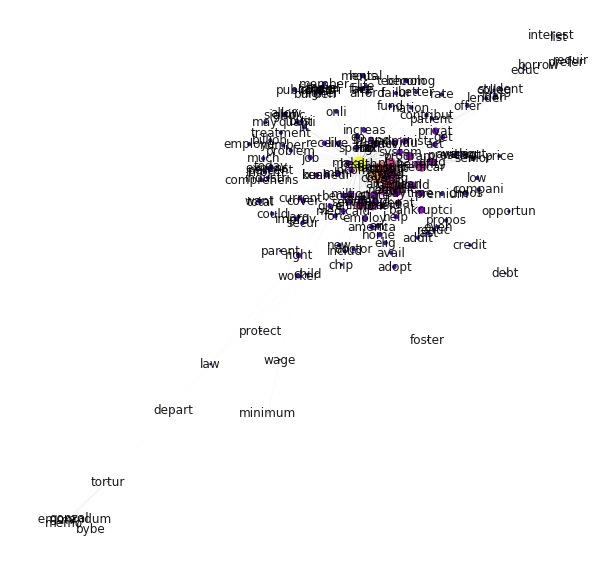

In [67]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Note how the colors reveal a much more graduate distribution here. Let's look at it directly.

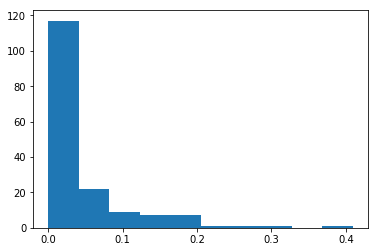

In [68]:
plt.hist(list(centralities.values()))
plt.show()

Top and bottom:

In [69]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.4094054865146399),
 ('care', 0.31410360905649326),
 ('cost', 0.26371184725651686),
 ('year', 0.22637895749862913),
 ('famili', 0.2030799342797031),
 ('plan', 0.19108150428848952),
 ('american', 0.18794543829229576),
 ('bill', 0.1771462778714309),
 ('insur', 0.17568249050178808),
 ('medicar', 0.16513397986452108)]

In [70]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('interest', 0.0011729540088679334),
 ('requir', 0.0011729540088679334),
 ('tortur', 0.0002281191238445879),
 ('depart', 0.00022454856713851975),
 ('minimum', 9.793307562753287e-05),
 ('gonzal', 1.4632892023819256e-05),
 ('mr', 1.3319282015842166e-05),
 ('memo', 1.262643903585993e-05),
 ('memorandum', 1.262643903585993e-05),
 ('bybe', 1.1865270167541126e-05)]

We can now filter our network by a centrality measure. Let's define a function and experiment with it:

In [49]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [72]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 111
Average degree:   8.8800


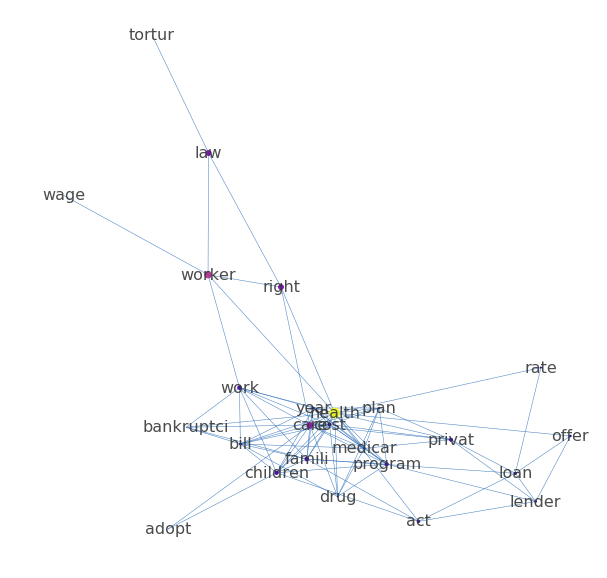

In [73]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

We can also look at global statistics, like the density of a network, defined as the number of actual edges divided by the total number of possible edges:

In [74]:
nx.density(giant)

0.0362175976633808

We can also calculate the average degree per node:

In [75]:
np.mean([v for w,v in nx.degree(giant)])

5.975903614457831

The diameter calculates the average distance between any two nodes in the network:

In [76]:
nx.diameter(giant)

7

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

#### Degree centrality

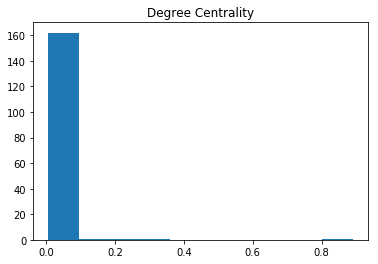

In [34]:
music_dcentralities = nx.degree_centrality(music_giant)
plt.hist(list(music_dcentralities.values()))
plt.title('Degree Centrality')
plt.show()

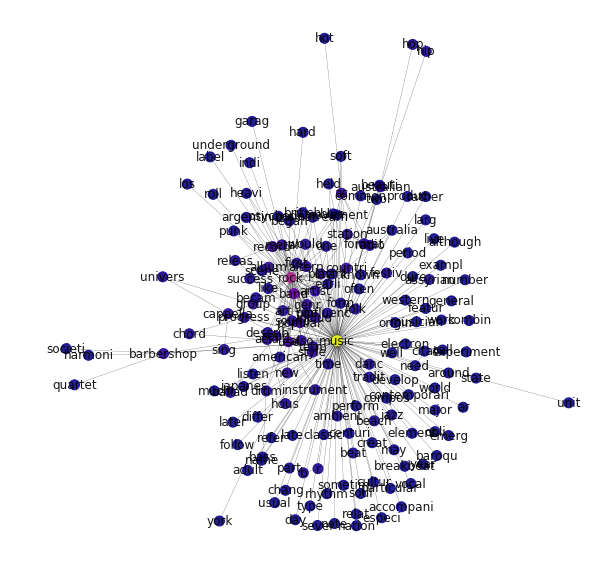

In [32]:
# Plot
fig, ax = plt.subplots(figsize = (10,10))
music_maxC = max(music_dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(music_giant, ax = ax, pos = layout, labels = {n:n for n in music_giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [music_dcentralities[n] / maxC for n in music_giant.nodes],
        cmap = plt.get_cmap('plasma')) 

In [36]:
# Most central words
sorted(music_dcentralities.items(), key = lambda x: x[1], reverse = True)[:15]

[('music', 0.8909090909090909),
 ('rock', 0.3515151515151515),
 ('band', 0.18787878787878787),
 ('use', 0.09696969696969697),
 ('song', 0.07272727272727272),
 ('popular', 0.06666666666666667),
 ('countri', 0.06060606060606061),
 ('artist', 0.06060606060606061),
 ('record', 0.05454545454545454),
 ('ac', 0.05454545454545454),
 ('style', 0.048484848484848485),
 ('barbershop', 0.048484848484848485),
 ('includ', 0.048484848484848485),
 ('metal', 0.048484848484848485),
 ('genr', 0.048484848484848485)]

In [37]:
# Least central words
sorted(music_dcentralities.items(), key = lambda x: x[1], reverse = True)[-15:]

[('larg', 0.006060606060606061),
 ('element', 0.006060606060606061),
 ('emerg', 0.006060606060606061),
 ('produc', 0.006060606060606061),
 ('garag', 0.006060606060606061),
 ('around', 0.006060606060606061),
 ('perform', 0.006060606060606061),
 ('exampl', 0.006060606060606061),
 ('classic', 0.006060606060606061),
 ('especi', 0.006060606060606061),
 ('dure', 0.006060606060606061),
 ('may', 0.006060606060606061),
 ('experiment', 0.006060606060606061),
 ('creat', 0.006060606060606061),
 ('ar', 0.006060606060606061)]

#### Betweenness centrality

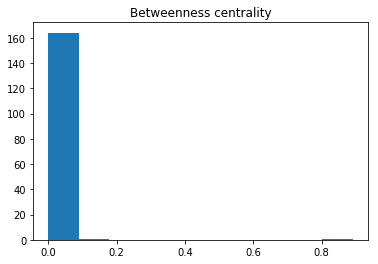

In [35]:
music_centralities = nx.betweenness.betweenness_centrality(music_giant)
# Histogram
plt.hist(list(music_centralities.values()))
plt.title('Betweenness centrality')
plt.show()

In [38]:
# Most central words
sorted(music_centralities.items(), key = lambda x: x[1], reverse = True)[:15]

[('music', 0.8911465702319362),
 ('rock', 0.12951175518248684),
 ('barbershop', 0.03617886178861789),
 ('australian', 0.02409460458240946),
 ('band', 0.018973973181290262),
 ('record', 0.012466124661246605),
 ('ac', 0.012318305001231832),
 ('new', 0.012133530426213351),
 ('state', 0.012121212121212121),
 ('use', 0.008567117164678137),
 ('group', 0.007486889803962973),
 ('progress', 0.005339633266462538),
 ('cappella', 0.004991553162284868),
 ('metal', 0.0038112835673811277),
 ('song', 0.003245257452574526)]

In [39]:
# Least central words
sorted(music_centralities.items(), key = lambda x: x[1], reverse = True)[-15:]

[('produc', 0.0),
 ('garag', 0.0),
 ('around', 0.0),
 ('perform', 0.0),
 ('exampl', 0.0),
 ('classic', 0.0),
 ('australia', 0.0),
 ('especi', 0.0),
 ('need', 0.0),
 ('dure', 0.0),
 ('may', 0.0),
 ('experiment', 0.0),
 ('jazz', 0.0),
 ('creat', 0.0),
 ('ar', 0.0)]

#### Closeness centrality

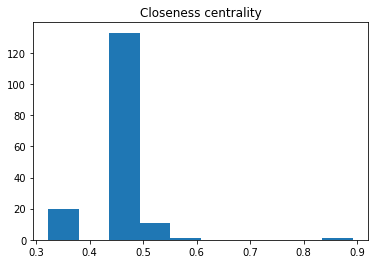

In [40]:
music_c_centralities = nx.closeness_centrality(music_giant)
# Histogram
plt.hist(list(music_c_centralities.values()))
plt.title('Closeness centrality')
plt.show()

In [41]:
# Most central words
sorted(music_c_centralities.items(), key = lambda x: x[1], reverse = True)[:15]

[('music', 0.8918918918918919),
 ('rock', 0.5871886120996441),
 ('band', 0.5357142857142857),
 ('use', 0.5061349693251533),
 ('song', 0.5045871559633027),
 ('countri', 0.4984894259818731),
 ('popular', 0.49698795180722893),
 ('includ', 0.49698795180722893),
 ('artist', 0.49698795180722893),
 ('style', 0.4954954954954955),
 ('record', 0.4954954954954955),
 ('also', 0.4954954954954955),
 ('play', 0.4940119760479042),
 ('new', 0.4925373134328358),
 ('group', 0.4925373134328358)]

In [42]:
# Least central words
sorted(music_c_centralities.items(), key = lambda x: x[1], reverse = True)[-15:]

[('indi', 0.3707865168539326),
 ('underground', 0.3707865168539326),
 ('hard', 0.3707865168539326),
 ('garag', 0.3707865168539326),
 ('chord', 0.3374233128834356),
 ('univers', 0.3319919517102616),
 ('label', 0.3319919517102616),
 ('york', 0.3306613226452906),
 ('quartet', 0.32673267326732675),
 ('societi', 0.32673267326732675),
 ('harmoni', 0.32673267326732675),
 ('hot', 0.32608695652173914),
 ('hop', 0.3254437869822485),
 ('hip', 0.3254437869822485),
 ('unit', 0.32289628180039137)]

#### Eigenvector centrality

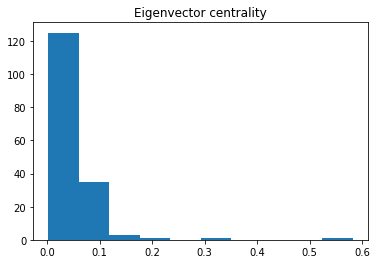

In [43]:
music_e_centralities = nx.eigenvector_centrality(music_giant)
# Histogram
plt.hist(list(music_e_centralities.values()))
plt.title('Eigenvector centrality')
plt.show()

In [44]:
# Most central words
sorted(music_e_centralities.items(), key = lambda x: x[1], reverse = True)[:15]

[('music', 0.5818918148322726),
 ('rock', 0.3343868892373942),
 ('band', 0.23068447938372538),
 ('use', 0.14243746964049053),
 ('popular', 0.12371769223410861),
 ('song', 0.12015853279019335),
 ('artist', 0.11631273190719571),
 ('includ', 0.11349025697083756),
 ('also', 0.10818072922066238),
 ('genr', 0.10457484061881306),
 ('record', 0.09901565707263989),
 ('play', 0.09739467976826363),
 ('metal', 0.09646254675307074),
 ('style', 0.09504452643320227),
 ('countri', 0.09353688102536478)]

In [45]:
# Least central words
sorted(music_e_centralities.items(), key = lambda x: x[1], reverse = True)[-15:]

[('indi', 0.021966767734506613),
 ('underground', 0.021966767734506613),
 ('hard', 0.021966767734506613),
 ('garag', 0.021966767734506613),
 ('chord', 0.015324981939241093),
 ('univers', 0.00955176060435549),
 ('label', 0.006504708873497241),
 ('york', 0.005763511231652595),
 ('hot', 0.004098292598913038),
 ('hop', 0.0036303464633744877),
 ('hip', 0.0036303464633744877),
 ('quartet', 0.0035144051940913875),
 ('societi', 0.0035144051940913875),
 ('harmoni', 0.0035144051940913875),
 ('unit', 0.0025221069956356556)]

#### Global measures

In [46]:
# Global densigy
nx.density(music_giant)

0.02548375319459657

In [47]:
# Average degree per node
np.mean([v for w,v in nx.degree(music_giant)])

4.204819277108434

In [48]:
# Average distance
nx.diameter(music_giant)

4

<span style='color:blue'> Generally speaking, different centraliaty measures give similar most central words and least central words, but slight different remains. The most central words tend to be the most general words for music, such as 'music', 'song', 'rock', 'band', 'record' and so on. The least central words tend to be some specific words, such as 'harmony', 'underground', and 'australia'. 

<span style='color:blue'> Maybe due to some features of my corpus, the centrality measures actually give similar results. Sometimes the only difference is the order of the words. But I could clearly see that different measures give different distribution of centrality. The degree centrality and the betweenness centrality give extremely skewed distribution of centralities. The eigenvector centrality gives a distribution similar to poisson distribution. And tne closeness centrality gives a more-like normal distribution of centralities.

<span style='color:blue'> The global density of the corpus is approximately 0.0255. The average degree per node is approximately 4.2048. And the average distance between two nodes is 4. This telle me that my network is a sparsed network with deep structure. And it could clearly distinguish things in the semantic space.

# POS based networks

Now let's look at links between specific parts of speech within a network.

For this we will be using the `nltk` POS facilities instead of the Stanford ones. These are much faster, but also somewhat less accurate. (You get what you *pay* for in computational power).

Let's look at nouns co-occurring in sentences using the top 10 (by score) reddit posts on thread topics we have explored in prior sessions:

In [77]:
redditDF = pandas.read_csv('../data/reddit.csv', index_col = 0)

In [78]:
redditTopScores = redditDF.sort_values('score')[-100:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[:3]

author  over_18  score                subreddit  \
99  jimmy_three_shoes    False   4990  Tales From Tech Support   
98         badbfriend    False   5034            Relationships   
97             Fafrdr    False   5146            Relationships   

                                                 text  \
99  This happened a little while ago, when I was c...   
98  https://www.reddit.com/r/relationships/comment...   
97  First post: https://www.reddit.com/r/relations...   

                                                title  \
99   We've tried nothing, and we're all out of ideas!   
98  Me [29 M] with my g/f [27 F] together 4 years,...   
97  Update - My [16F] father [59M] acts creepy tow...   

                                                  url  \
99  https://www.reddit.com/r/talesfromtechsupport/...   
98  https://www.reddit.com/r/relationships/comment...   
97  https://www.reddit.com/r/relationships/comment...   

                                            sentences  
99  [[This, happened, a, little, while, ago, ,, wh...  
98  [[https, :, //www.reddit.com/r/relationships/c...  
97  [[First, post, :, https, :, //www.reddit.com/r...

Now we'll normalize the tokens through stemming:

In [79]:
redditTopScores['normalized_sents'] = redditTopScores['sentences'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = None, stemmer = lucem_illud.stemmer_basic) for s in x])

In [51]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in nltk.pos_tag(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [81]:
gNN = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN')

In [82]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 2635
Number of edges: 26238
Average degree:  19.9150


This is a bit too large to effectively visualize, so let's remove the vertices with degree less than or equal to 100:

In [83]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 100]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 87
Number of edges: 1922
Average degree:  44.1839


And low weight edges:

In [84]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 2])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 87
Number of edges: 486
Average degree:  11.1724


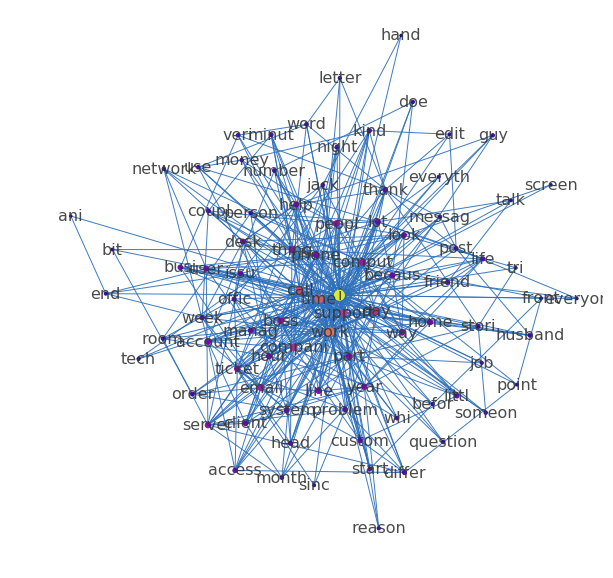

In [85]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

That is an interesting pattern; everyone is talking about themselves ("I...this", "I...that").

What if we want to look at noun-verb pairs instead?

In [86]:
gNV = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN', 'VB')

`gNV` has co-occurrences between nouns and nouns as well as between verbs and verbs. Let's remove these and make it purely about noun and verb combinations:

In [87]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2871
Number of edges: 40611
Average degree:  28.2905


In [88]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [89]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2871
Number of edges: 13366
Average degree:   9.3110


Dropping low weight edges and low degree vertices gives us:

In [90]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 2])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 5])

In [91]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 82
Number of edges: 450
Average degree:  10.9756


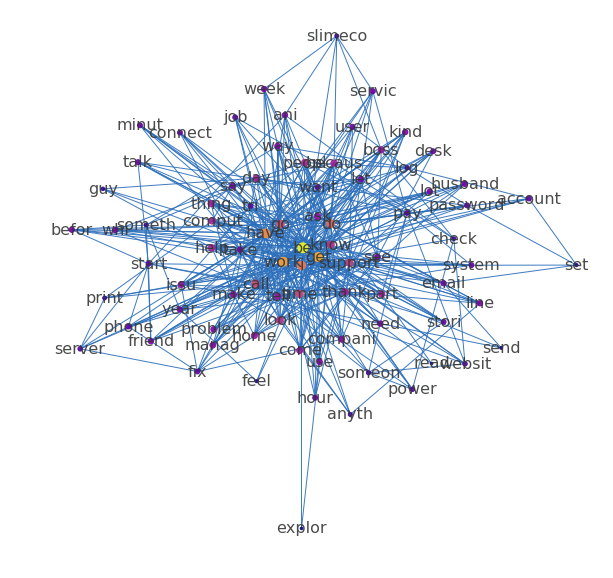

In [92]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

Lets create an "ego network" surrounding a single (important) word, as we did before:

In [93]:
g_i = gNV.subgraph(['i'] + list(gNV.neighbors('i')))

In [94]:
print(nx.info(g_i))

Name: 
Type: SubGraph
Number of nodes: 34
Number of edges: 33
Average degree:   1.9412


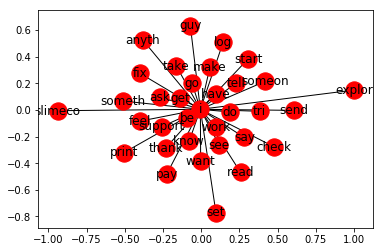

In [95]:
nx.draw_networkx(g_i)

Instead of just nodes connected to a vertex, we can find all those connected to it within 2 hops, lets look at 'stori' for this:

In [96]:
storyNeighbors = gNV.neighbors('stori')
set(storyNeighbors)

{'be', 'get', 'know', 'someon', 'support', 'thank', 'tri'}

In [97]:
storyNeighbors = set(gNV.neighbors('stori'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))

In [98]:
gNV_story = gNV.subgraph(storyNeighborsPlus1)
print(nx.info(gNV_story))

Name: 
Type: SubGraph
Number of nodes: 56
Number of edges: 161
Average degree:   5.7500


This is a mid-sized network, but we can interrogate it intelligently by computing some statistics. Degree centrality:

In [99]:
sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('be', 0.8727272727272727),
 ('get', 0.7090909090909091),
 ('support', 0.39999999999999997),
 ('know', 0.36363636363636365),
 ('thank', 0.3090909090909091),
 ('tri', 0.14545454545454545),
 ('stori', 0.12727272727272726),
 ('call', 0.12727272727272726),
 ('i', 0.12727272727272726),
 ('someon', 0.12727272727272726)]

Or eigenvector centrality:

In [100]:
sorted(nx.eigenvector_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('be', 0.43928984202898536),
 ('get', 0.38266314108290167),
 ('support', 0.24421847103891117),
 ('know', 0.21111457825779462),
 ('thank', 0.19442994690119703),
 ('stori', 0.15627933587529894),
 ('call', 0.15627933587529894),
 ('i', 0.15627933587529894),
 ('help', 0.14825532139380795),
 ('issu', 0.14825532139380795)]

Notice that 'stori' isn't even in the top 5:

Lets plot it:

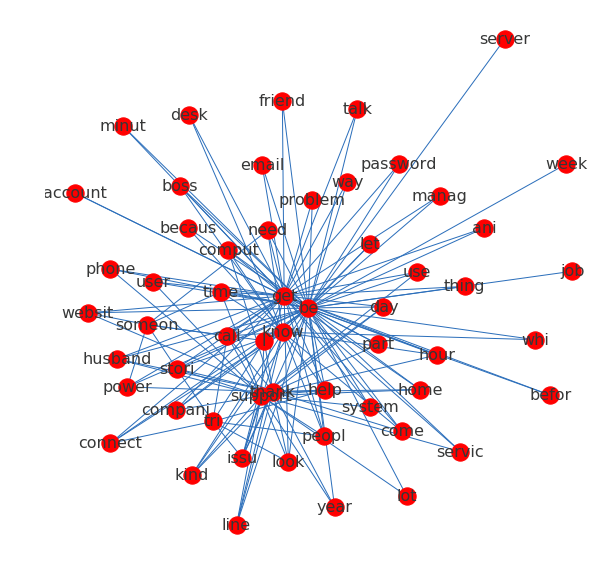

In [101]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

"I" is still in the middle. These are stories about the self.

Lets create a noun-adjective network:

In [102]:
gNJ = posCooccurrence(recdditTopScores['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

Name: 
Type: Graph
Number of nodes: 3114
Number of edges: 42799
Average degree:  27.4881


By filtering by a centrality measure we can get a more 'central' set of nodes instead of just the most connected.

In [103]:
gNJ_filtered200 = filterWords(gNJ, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 74
Average degree:   5.9200


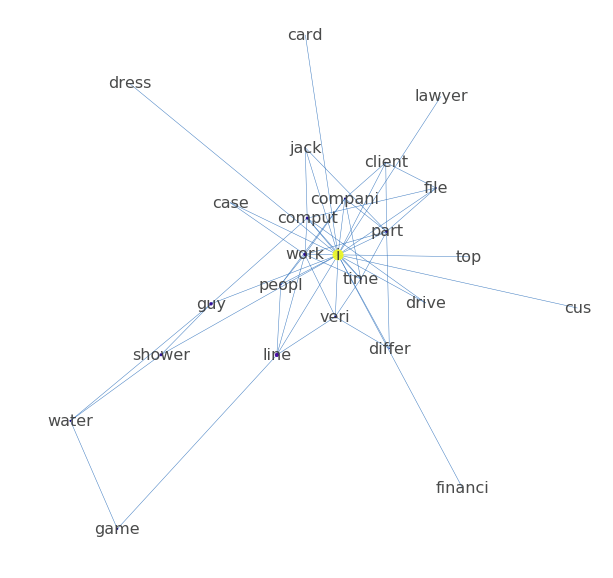

In [104]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

A truly self-centered network.

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, which illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful? 

<span style="color:red">***Stretch***: Graph some word-centered "ego-networks" with words one link away, two links away, and three links away (we only did up to two links away above).

<span style="color:blue"> Here I generate a noun-noun network and a noun-adjective network, to compare the network relationships among words in my music corpus. My interest in this topic is whether I could find any connection among music elements. Since it takes a very long time for the 'filterWords' function to run, I do not use this function to reduce the dimension of the network here. I directly remove nodes with relatively less neighbors and edges with relatively less weights. And I make both of the networks have approximately 100 nodes with 630 to 680 edges.

### Noun-noun Network

In [61]:
music_gNN = posCooccurrence(df['normalized_sents'][:100].sum(), 'NN')
# Check dimension
print(nx.info(music_gNN))

Name: 
Type: Graph
Number of nodes: 8533
Number of edges: 223969
Average degree:  52.4948


In [53]:
# Remove less frequently connected nodes
music_gNN.remove_nodes_from([n for n in music_gNN.nodes if len(set(music_gNN.neighbors(n))) <= 450]) 
print(nx.info(music_gNN))

# Remove less weighted edges
music_gNN.remove_edges_from([(n1, n2) for n1, n2, d in music_gNN.edges(data = True) if d['weight'] <= 15])
print(nx.info(music_gNN))

Name: 
Type: Graph
Number of nodes: 116
Number of edges: 5753
Average degree:  99.1897
Name: 
Type: Graph
Number of nodes: 116
Number of edges: 680
Average degree:  11.7241


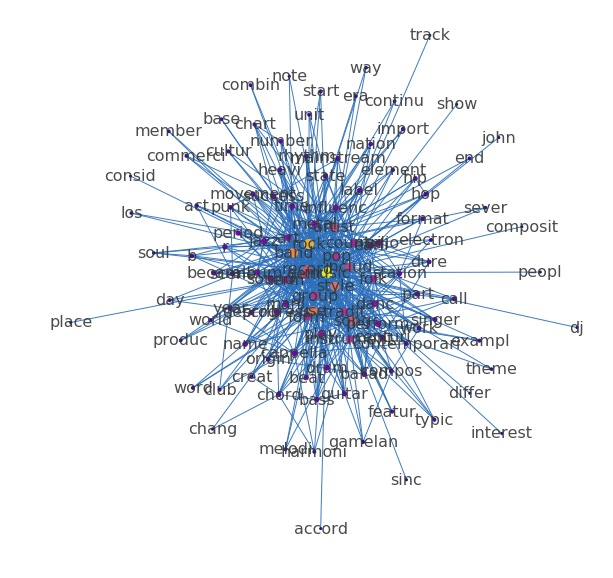

In [54]:
layout_nn = nx.spring_layout(music_gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(music_gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in music_gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in music_gNN.edges(data = True)))
nx.draw(music_gNN, ax = ax, pos = layout_nn, labels = {n: n for n in music_gNN.nodes()},
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in music_gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in music_gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [65]:
# Degree centrality: most central words
sorted(nx.degree_centrality(music_gNN).items(), key = lambda x: x[1], reverse = True)[:15]

[('music', 0.5057430848570089),
 ('band', 0.266643225503985),
 ('rock', 0.25035161744022505),
 ('includ', 0.24109235818096578),
 ('use', 0.22609001406469761),
 ('record', 0.21788560712611346),
 ('song', 0.2088607594936709),
 ('style', 0.2047585560243788),
 ('artist', 0.2005391467416784),
 ('group', 0.17522269104547586),
 ('form', 0.17287857477730897),
 ('instrument', 0.15447726207219878),
 ('tradit', 0.1537740271917487),
 ('genr', 0.15353961556493204),
 ('play', 0.153187998124707)]

In [66]:
# Eigenvector centrality: most central words
sorted(nx.eigenvector_centrality(music_gNN).items(), key = lambda x: x[1], reverse = True)[:15]

[('music', 0.15704623012114588),
 ('band', 0.11092735843839269),
 ('rock', 0.1090822350872542),
 ('use', 0.10659041248719738),
 ('includ', 0.10386486901598851),
 ('record', 0.10237973140539204),
 ('style', 0.1013052888091342),
 ('song', 0.10039000967502969),
 ('artist', 0.09559927558081346),
 ('group', 0.09210063594176898),
 ('form', 0.0900381850758642),
 ('genr', 0.08768101450869954),
 ('play', 0.0870991187672133),
 ('tradit', 0.08545337981577794),
 ('time', 0.08405055615834714)]

Name: 
Type: SubGraph
Number of nodes: 980
Number of edges: 43891
Average degree:  89.5735


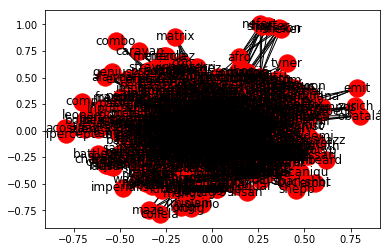

In [117]:
# Ego network of 'jazz'
g_jazz1 = music_gNN.subgraph(['jazz'] + list(music_gNN.neighbors('jazz')))
print(nx.info(g_jazz1))
# Plot
nx.draw_networkx(g_jazz1)

In [116]:
# Ego network of 'rock'
g_rock = music_gNN.subgraph(['rock'] + list(music_gNN.neighbors('rock')))
print(nx.info(g_rock))

Name: 
Type: SubGraph
Number of nodes: 2135
Number of edges: 88244
Average degree:  82.6642


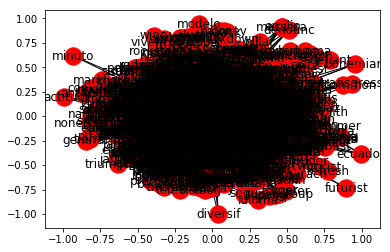

In [70]:
# Plot
nx.draw_networkx(g_rock)

In [74]:
rockNeighbors = set(music_gNN.neighbors('rock'))
rockNeighborsPlus1 = set(rockNeighbors)
for n in rockNeighbors:
    rockNeighborsPlus1 |= set(music_gNN.neighbors(n))

gNN_rock = music_gNN.subgraph(rockNeighborsPlus1)
print(nx.info(gNN_rock))

Name: 
Type: SubGraph
Number of nodes: 8466
Number of edges: 223786
Average degree:  52.8670


In [105]:
rockNeighborsPlus2 = set(gNN_rock)
for n in gNN_rock:
    rockNeighborsPlus2 |= set(music_gNN.neighbors(n))

gNN_rock2 = music_gNN.subgraph(rockNeighborsPlus2)
print(nx.info(gNN_rock2))

Name: 
Type: SubGraph
Number of nodes: 8519
Number of edges: 223964
Average degree:  52.5799


In [106]:
rockNeighborsPlus3 = set(gNN_rock2)
for n in gNN_rock2:
    rockNeighborsPlus3 |= set(music_gNN.neighbors(n))

gNN_rock3 = music_gNN.subgraph(rockNeighborsPlus3)
print(nx.info(gNN_rock3))

Name: 
Type: SubGraph
Number of nodes: 8519
Number of edges: 223964
Average degree:  52.5799


In [107]:
list(rockNeighbors)[:10]

['struggl',
 'feroz',
 'sublim',
 'slogan',
 'attract',
 'banda',
 'practition',
 'imposs',
 'procol',
 'mind']

In [111]:
list(gNN_rock)[:10]

['creol',
 'tanbou',
 'tribut',
 'hanna',
 'attract',
 'mira',
 'mehter',
 'exposit',
 'weather',
 'procol']

In [112]:
list(gNN_rock2)[:10]

['creol',
 'tanbou',
 'tribut',
 'hanna',
 'attract',
 'mira',
 'mehter',
 'exposit',
 'weather',
 'procol']

In [113]:
list(gNN_rock3)[:10]

['creol',
 'tanbou',
 'tribut',
 'hanna',
 'attract',
 'mira',
 'mehter',
 'exposit',
 'weather',
 'procol']

### Noun-Adjective Network

In [58]:
music_gNJ = posCooccurrence(df['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(music_gNJ))

Name: 
Type: Graph
Number of nodes: 9949
Number of edges: 376265
Average degree:  75.6388


In [59]:
# Remove low weight edges and low frequency nodes
music_gNJ.remove_nodes_from([n for n in music_gNJ.nodes if len(set(music_gNJ.neighbors(n))) <= 800])
print(nx.info(music_gNJ))
music_gNJ.remove_edges_from([(n1, n2) for n1, n2, d in music_gNJ.edges(data = True) if d['weight'] <= 20])
print(nx.info(music_gNJ))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 4797
Average degree:  95.9400
Name: 
Type: Graph
Number of nodes: 100
Number of edges: 635
Average degree:  12.7000


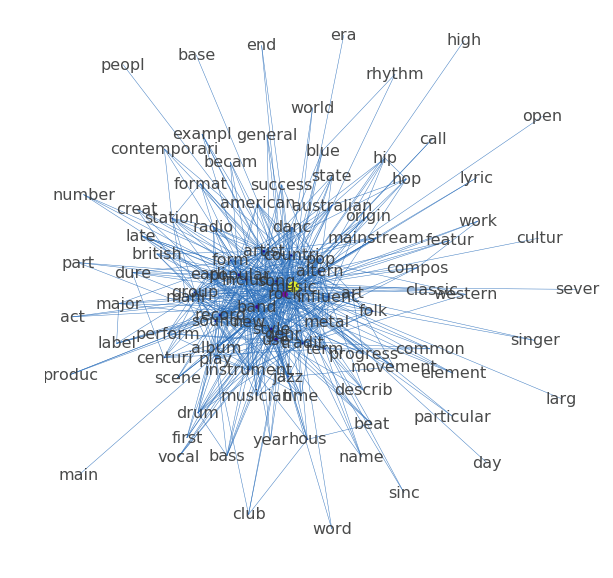

In [60]:
layout_NJ100 = nx.spring_layout(music_gNJ, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj100 = nx.betweenness_centrality(music_gNJ)
maxC = max(centralities_nj100.items(), key = lambda x : x[1])[1]
nx.draw(music_gNJ, ax = ax, pos = layout_NJ100, labels = {n: n for n in music_gNJ.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj100[n] / maxC for n in music_gNJ.nodes],
        node_size = [centralities_nj100[n] / maxC * 100 for n in music_gNJ.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

Name: 
Type: SubGraph
Number of nodes: 70
Number of edges: 509
Average degree:  14.5429


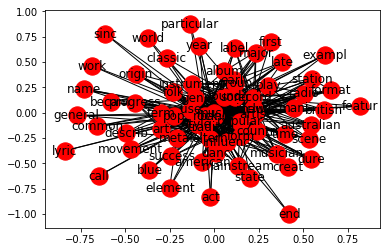

In [115]:
# Ego network
g_rock2 = music_gNJ.subgraph(['rock'] + list(music_gNJ.neighbors('rock')))
print(nx.info(g_rock2))
# Plot
nx.draw_networkx(g_rock2)

Name: 
Type: SubGraph
Number of nodes: 13
Number of edges: 72
Average degree:  11.0769


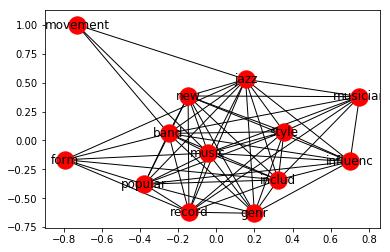

In [94]:
# Ego network
g_jazz = music_gNJ.subgraph(['jazz'] + list(music_gNJ.neighbors('jazz')))
print(nx.info(g_jazz2))
# Plot
nx.draw_networkx(g_jazz)

In [95]:
jazzNeighbors = set(music_gNJ.neighbors('jazz'))
jazzNeighborsPlus1 = set(jazzNeighbors)
for n in jazzNeighbors:
    jazzNeighborsPlus1 |= set(music_gNJ.neighbors(n))

gNJ_jazz = music_gNJ.subgraph(jazzNeighborsPlus1)
print(nx.info(gNJ_jazz))

Name: 
Type: SubGraph
Number of nodes: 100
Number of edges: 635
Average degree:  12.7000


In [102]:
jazzNeighborsPlus2 = set(gNJ_jazz)
for n in gNJ_jazz:
    jazzNeighborsPlus2 |= set(music_gNJ.neighbors(n))

gNJ_jazz2 = music_gNJ.subgraph(jazzNeighborsPlus2)
print(nx.info(gNJ_jazz2))

Name: 
Type: SubGraph
Number of nodes: 100
Number of edges: 635
Average degree:  12.7000


In [99]:
jazzNeighborsPlus3 = set(gNJ_jazz2)
for n in gNJ_jazz2:
    jazzNeighborsPlus3 |= set(music_gNJ.neighbors(n))

gNJ_jazz3 = music_gNJ.subgraph(jazzNeighborsPlus3)
print(nx.info(gNJ_jazz3))

Name: 
Type: SubGraph
Number of nodes: 100
Number of edges: 635
Average degree:  12.7000


In [118]:
set(gNJ_jazz) == set(gNJ_jazz2)

True

In [103]:
set(gNJ_jazz3) == set(gNJ_jazz2)

True

<span style="color:blue"> According to the network graphs, either in the noun-noun network or in the noun-adjective network, the word 'music' is always the most central word. Different music genres have different position in the networks. For example, both rock music and pop music are very to the center, having connection with many other music genres and music elements. Hip hop is far away from the center in both networks. However, in the noun-noun network, pop music is closer to the center than rock music, while rock music is closer to the center than pop music in the noun-adjective network. I guess the reason is rock music appears more with many frequently used nouns while pop music appears more with frequently used adjectives.

<span style='color:blue'> Scretch. I draw the ego networks for both 'jazz' and 'rock'. The network of 'rock' is more messy than the network of 'jazz', since 'rock' is more central than 'jazz'. And as I tried to generate network of one link away, two links away, three links away, and four links away, I find that the latter three are the same. So it makes sense to not exceed two links away.

# Interactional influence

In a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdf/1411.2674.pdf), the authors develop a method to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network. Here we walk through this method, which relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

### First let's look at the output of their analysis:

In [175]:
example_name = '12-angry-men'   #example datasets: "12-angry-men" or "USpresident"

In [176]:
result_path = '../data/Bayesian-echo/results/{}/'.format(example_name)
if not os.path.isdir(result_path):
    raise ValueError('Invalid example selected, only "12-angry-men" or "USpresident" are avaliable')

In [177]:
df_meta_info = pandas.read_table(result_path + 'meta-info.txt',header=None)
df_log_prob = pandas.read_csv(result_path + "SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pandas.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pandas.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pandas.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id


Person : ID


{'Foreman': 3,
 'Juror 10': 2,
 'Juror 11': 6,
 'Juror 12': 7,
 'Juror 2': 9,
 'Juror 3': 1,
 'Juror 4': 5,
 'Juror 5': 11,
 'Juror 6': 8,
 'Juror 7': 4,
 'Juror 8': 0,
 'Juror 9': 10}

In [150]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

### Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

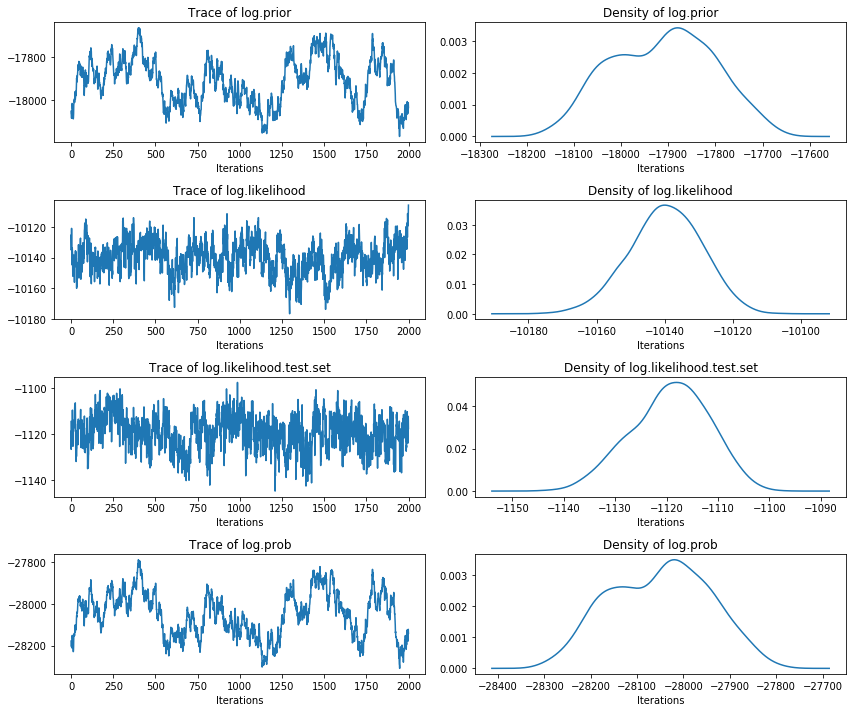

In [178]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

### Plot the influence matrix between participants

In [179]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [111]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pandas.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [112]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

In [113]:
df_mean

Juror 8   Juror 3  Juror 10   Foreman   Juror 7   Juror 4  \
Juror 8   0.000000  3.757957  8.089079  0.930180  5.167497  0.794645   
Juror 3   8.529312  0.000000  6.673916  4.150076  2.534751  4.902852   
Juror 10  8.413188  7.427932  0.000000  4.540236  3.216307  1.030049   
Foreman   1.137060  0.612615  1.945196  0.000000  1.521390  0.834870   
Juror 7   2.603853  5.901169  0.648844  1.969868  0.000000  1.110101   
Juror 4   5.791320  0.200669  0.266484  0.582956  0.094200  0.000000   
Juror 11  0.378515  0.544628  0.779340  0.454645  0.290575  0.447512   
Juror 12  5.961338  0.695831  0.519459  1.253033  0.247939  0.162463   
Juror 6   4.526244  0.923784  0.503503  1.049825  1.288920  0.451562   
Juror 2   0.583732  2.303417  0.529583  1.722894  2.005939  0.299311   
Juror 9   1.216641  1.281288  0.967587  1.675483  1.657341  1.681338   
Juror 5   0.552951  1.001575  0.696393  1.180245  1.180355  0.497265   

          Juror 11  Juror 12   Juror 6   Juror 2   Juror 9   Juror 5  
Juror 8   0.845335  1.336329  6.106684  0.916765  6.385205  7.300776  
Juror 3   1.092571  0.509942  3.825015  3.861767  0.266426  1.561626  
Juror 10  1.004598  0.529232  2.426582  0.407460  1.233599  0.885871  
Foreman   1.338554  3.230634  1.013511  3.534036  1.311436  4.115411  
Juror 7   0.279870  0.608548  1.047693  2.910670  1.619475  1.570038  
Juror 4   3.347982  0.316963  0.300770  2.112033  0.370973  0.673364  
Juror 11  0.000000  0.614536  0.821143  0.951222  0.476986  0.844157  
Juror 12  0.388620  0.000000  2.500976  2.375977  0.481394  0.834032  
Juror 6   0.375776  0.904313  0.000000  2.861587  0.905421  0.310822  
Juror 2   0.652302  1.623813  0.841376  0.000000  1.691612  1.756225  
Juror 9   0.623032  1.925996  1.907992  0.539666  0.000000  1.138934  
Juror 5   0.786181  0.588822  0.724613  0.912616  1.224854  0.000000

MEAN of influence matrix (row=from, col=to)


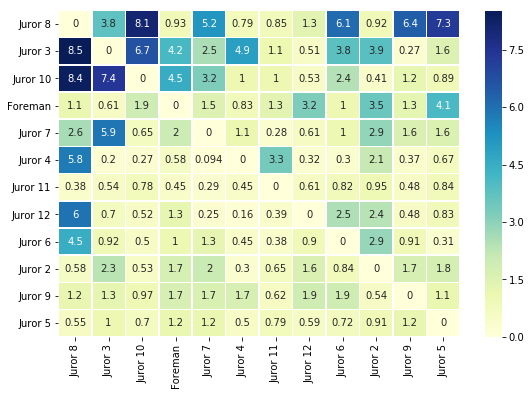

In [114]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

SD of influence matrix (row=from, col=to)


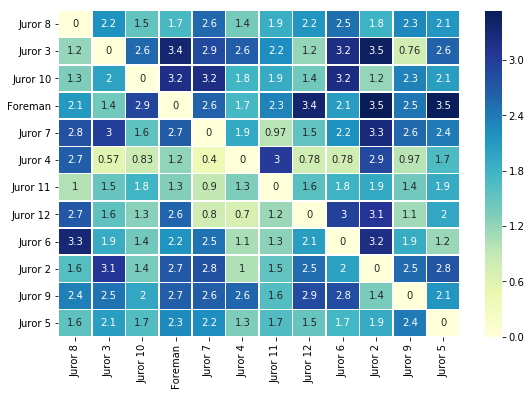

In [115]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

### Barplot of total influences sent/received

In [116]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

Total influence:

		Total linguistic influence sent/received 


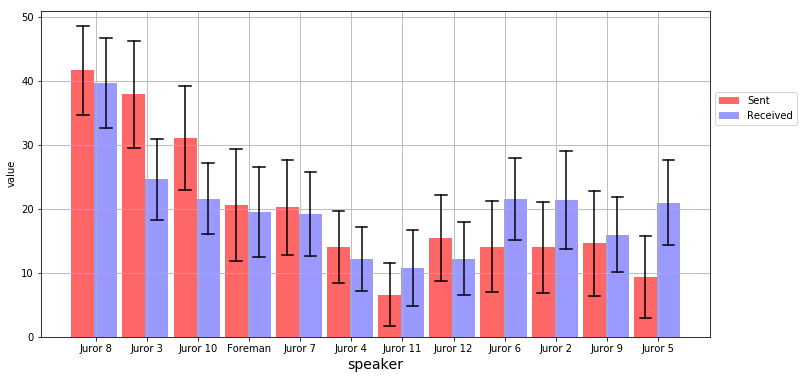

In [117]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

## Visualize Influence Network!

You can visualize any of the influence matrices above:

Using networkx:

In [118]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [119]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

Mean Influence Network


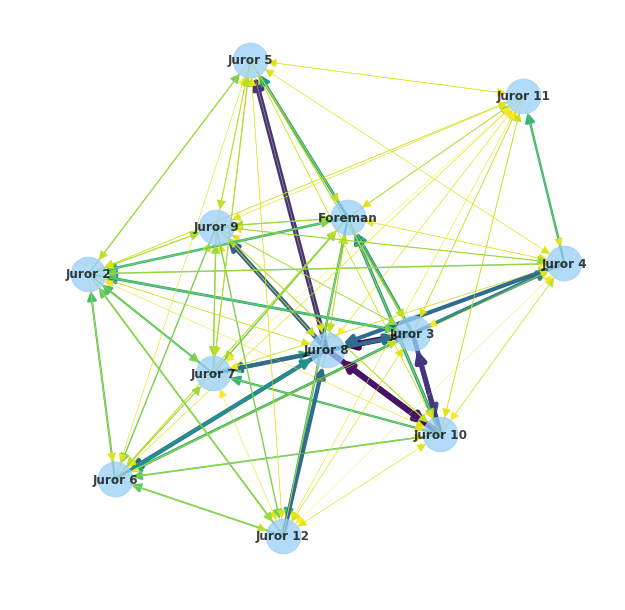

In [120]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

25 Quantile Influence Network


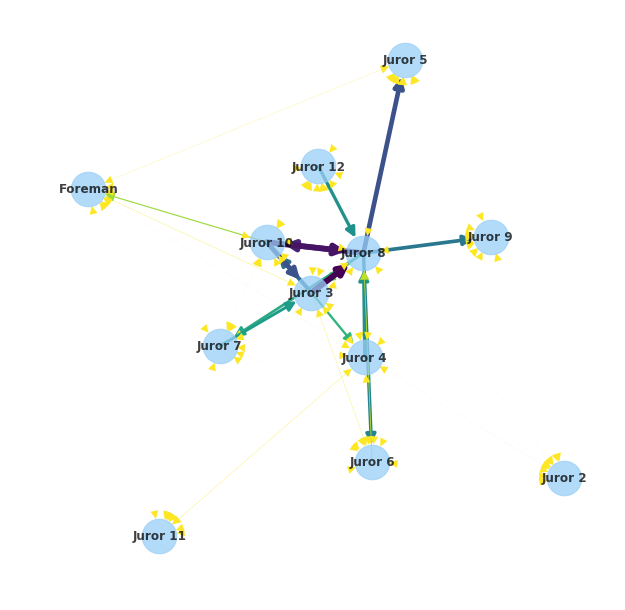

In [121]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

75 Quantile Influence Network


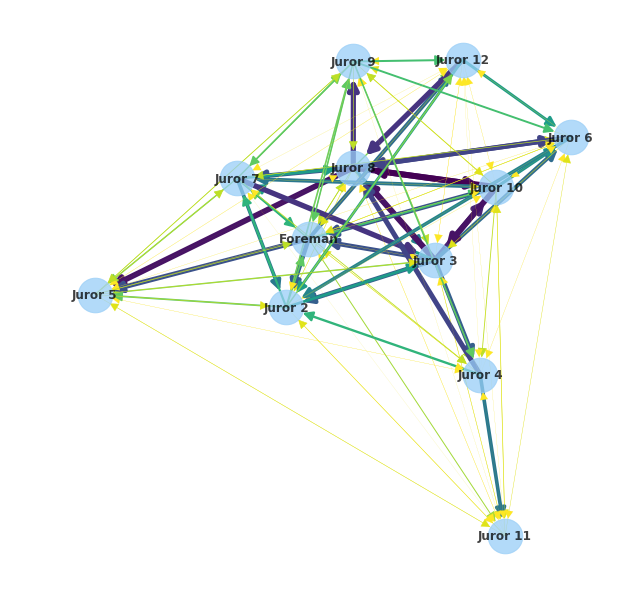

In [122]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

In [2]:
import lucem_illud
import pandas
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

Your own dataset should contains 4 columns (with the same column names) as the artificial one below:

- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minutes','hours'...)
- end: ending time of utterance (same unit as start)

There is no need to sort data for the moment.

Below, we generate a fake collection of data from "Obama", "Trump", "Clinton"...and other recent presidents. You can either create your own simulation OR (better), add real interactional data from a online chat forum, comment chain, or transcribed from a conversation.

In [3]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pandas.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript[:2]

name                                             tokens     start  \
0  Kennedy  [ejea, cfie, glis, eljf, jesi, jdgb, decd, gkg...  0.580803   
1     Bush  [gfkh, jfac, sfei, cjgl, kllb, eflb, ggaa, dkk...  2.527068   

        end  
0  1.288779  
1  3.943926

Transform data into TalkbankXML format:

In [4]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud.make_TalkbankXML(df_transcript, output_fname, language = language )

New File saved to ./data/USpresident/USpresident.xml


0

Run Bayesian Echo Chamber to get estimation.

- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [5]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud.bec_run(output_fname, Vocab_size, language, sampling_time)

Realtime output can be viewed in shell.

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that either (1) take data from a transcribed conversation, online chat forum, comment chain or some other *timed* interaction and calculate Bayesian influence; or (2) build a simulation similar in spirit to the "Presidents" example above, ideally infusing it with interesting "stylized facts". What does that estimation and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

In [127]:
amc_df = pandas.read_csv('../../content_analysis_project/amc1.csv')
amc_sample = amc_df.iloc[:48]

In [133]:
# Tokenize text. Since the sentences in the transcripts contains too many stop words, here I keep the stop words to retain the sentences.
amc_sample['tokenized_text'] = amc_sample['speech'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [140]:
# Generate start time and end time according to the length of the speeches.
amc_sample['start'] = np.nan
amc_sample['end'] = np.nan
total_time = 0

for i in range(amc_sample.shape[0]):
    amc_sample['start'].iloc[i] = total_time + 1/3
    duration = len(amc_sample['speech'].iloc[i].split())
    total_time = total_time + 1/3 + duration/3
    amc_sample['end'].iloc[i] = total_time

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

In [141]:
amc_sample

Unnamed: 0           filename opera_name  show_year show_date  scene  \
0            0  2001/04-09-01.txt        amc       2001  04-09-01      1   
1            1  2001/04-09-01.txt        amc       2001  04-09-01      1   
2            2  2001/04-09-01.txt        amc       2001  04-09-01      1   
3            3  2001/04-09-01.txt        amc       2001  04-09-01      1   
4            4  2001/04-09-01.txt        amc       2001  04-09-01      1   
5            5  2001/04-09-01.txt        amc       2001  04-09-01      1   
6            6  2001/04-09-01.txt        amc       2001  04-09-01      1   
7            7  2001/04-09-01.txt        amc       2001  04-09-01      1   
8            8  2001/04-09-01.txt        amc       2001  04-09-01      1   
9            9  2001/04-09-01.txt        amc       2001  04-09-01      1   
10          10  2001/04-09-01.txt        amc       2001  04-09-01      1   
11          11  2001/04-09-01.txt        amc       2001  04-09-01      1   
12          12  2001/04-09-01.txt        amc       2001  04-09-01      1   
13          13  2001/04-09-01.txt        amc       2001  04-09-01      1   
14          14  2001/04-09-01.txt        amc       2001  04-09-01      1   
15          15  2001/04-09-01.txt        amc       2001  04-09-01      1   
16          16  2001/04-09-01.txt        amc       2001  04-09-01      1   
17          17  2001/04-09-01.txt        amc       2001  04-09-01      1   
18          18  2001/04-09-01.txt        amc       2001  04-09-01      1   
19          19  2001/04-09-01.txt        amc       2001  04-09-01      1   
20          20  2001/04-09-01.txt        amc       2001  04-09-01      1   
21          21  2001/04-09-01.txt        amc       2001  04-09-01      1   
22          22  2001/04-09-01.txt        amc       2001  04-09-01      1   
23          23  2001/04-09-01.txt        amc       2001  04-09-01      1   
24          24  2001/04-09-01.txt        amc       2001  04-09-01      1   
25          25  2001/04-09-01.txt        amc       2001  04-09-01      1   
26          26  2001/04-09-01.txt        amc       2001  04-09-01      1   
27          27  2001/04-09-01.txt        amc       2001  04-09-01      1   
28          28  2001/04-09-01.txt        amc       2001  04-09-01      1   
29          29  2001/04-09-01.txt        amc       2001  04-09-01      1   
30          30  2001/04-09-01.txt        amc       2001  04-09-01      1   
31          31  2001/04-09-01.txt        amc       2001  04-09-01      1   
32          32  2001/04-09-01.txt        amc       2001  04-09-01      1   
33          33  2001/04-09-01.txt        amc       2001  04-09-01      1   
34          34  2001/04-09-01.txt        amc       2001  04-09-01      1   
35          35  2001/04-09-01.txt        amc       2001  04-09-01      1   
36          36  2001/04-09-01.txt        amc       2001  04-09-01      1   
37          37  2001/04-09-01.txt        amc       2001  04-09-01      1   
38          38  2001/04-09-01.txt        amc       2001  04-09-01      1   
39          39  2001/04-09-01.txt        amc       2001  04-09-01      1   
40          40  2001/04-09-01.txt        amc       2001  04-09-01      1   
41          41  2001/04-09-01.txt        amc       2001  04-09-01      1   
42          42  2001/04-09-01.txt        amc       2001  04-09-01      1   
43          43  2001/04-09-01.txt        amc       2001  04-09-01      1   
44          44  2001/04-09-01.txt        amc       2001  04-09-01      1   
45          45  2001/04-09-01.txt        amc       2001  04-09-01      1   
46          46  2001/04-09-01.txt        amc       2001  04-09-01      1   
47          47  2001/04-09-01.txt        amc       2001  04-09-01      1   

    turn                                               text  speaker  \
0      1                  Ryan: You look beyond beautiful.      Ryan   
1      2                               Gillian: So do you.   Gillian   
2      3                                 Ryan: That dress.     

In [142]:
amc_use = amc_sample[['speaker', 'tokenized_text', 'start', 'end']]
amc_use.columns = ['name', 'tokens', 'start', 'end']

In [148]:
amc_use

name                                             tokens       start  \
0      Ryan                [[You, look, beyond, beautiful, .]]    0.333333   
1   Gillian                                 [[So, do, you, .]]    2.000000   
2      Ryan                                 [[That, dress, .]]    3.333333   
3   Gillian  [[It, was, my, great-great-grandmother, 's, .]...    4.333333   
4      Ryan                 [[How, do, you, like, my, tux, ?]]    9.666667   
5   Gillian                    [[You, are, quite, dashing, .]]   12.000000   
6      Ryan  [[Dimitri, arranged, it, .], [Everything, from...   13.666667   
7   Dimitri  [[You, know, ,, I, wish, I, could, say, that, ...   18.000000   
8   Gillian                             [[It, 's, perfect, .]]   26.666667   
9   Dimitri  [[It, 's, your, wedding, day, .], [Street, clo...   27.666667   
10     Ryan  [[Wow, .], [Looks, familiar, ,, does, n't, it,...   36.666667   
11  Gillian  [[Yeah, .], [We, 've, walked, down, this, aisl...   38.666667   
12     Ryan  [[Yes, ,, we, have, ,, but, this, time, we, 'r...   41.666667   
13  Gillian  [[This, time, our, vows, will, be, final, and,...   46.000000   
14     Ryan  [[Dimitri, ,, it, means, a, lot, to, have, the...   49.333333   
15  Gillian  [[Oh, ,, Dimitri, ,, I, ca, n't, believe, --, ...   53.666667   
16  Dimitri  [[Well, ,, I, did, n't, .], [No, ,, I, did, n'...   59.000000   
17  Gillian  [[Well, ,, we, did, n't, want, to, make, a, bi...   72.333333   
18  Dimitri  [[Oh, ,, please, ,, come, on, .], [It, 's, the...   75.666667   
19  Eugenia                                          [[Oh, !]]   90.333333   
20   Myrtle                                         [[Oh, --]]   91.000000   
21    Laura                        [[You, look, beautiful, !]]   92.000000   
22   Brooke                             [[Congratulations, .]]   93.333333   
23   Myrtle            [[Oh, ,, Gillian, ,, how, gorgeous, .]]   94.000000   
24   Edmund                                   [[Surprised, ?]]   95.666667   
25  Gillian  [[Oh, ,, Edmund, ,, I, ca, n't, believe, you, ...   96.333333   
26     Alex                             [[Are, you, happy, ?]]  100.000000   
27     Ryan  [[Yes, ,, we, are, .], [How, did, you, do, it,...  101.333333   
28   Edmund  [[Oh, ,, we, 're, just, sneaky, ,, that, 's, a...  109.000000   
29     Alex  [[Yeah, ,, we, had, --, the, elves, were, work...  111.333333   
30   Maddie        [[Were, there, really, elves, ,, Daddy, ?]]  115.333333   
31   Edmund                      [[Oh, ,, yeah, .], [Look, .]]  117.333333   
32   Maddie                         [[It, 's, pixie, dust, .]]  118.666667   
33   Edmund       [[It, is, ?], [Is, there, a, difference, ?]]  120.000000   
34     Alex  [[Oh, ,, he, 's, hopeless, .], [Come, on, ,, w...  122.333333   
35  Gillian  [[Oh, ,, look, how, grown, up, you, two, are, .]]  126.333333   
36     Ryan  [[Were, you, guys, behind, this, whole, surpri...  129.333333   
37  Eugenia  [[You, know, ,, talking, of, surprises, ,, som...  135.666667   
38  Gillian  [[[, Screams, ], Lazlo, !], [Bela, !], [These,...  144.000000   
39     Ryan                         [[Nice, to, meet, you, .]]  147.333333   
40   Brooke          [[Does, n't, Gillian, look, gorgeous, ?]]  149.000000   
41    Laura                     [[Yeah, .], [I, hate, her, .]]  150.666667   
42   Brooke                           [[Oh, ,, me, ,, too, .]]  152.333333   
43    Laura  [[Just, kidding, .], [Oh, ,, it, would, be, so...  153.666667   
44   Brooke          [[Late, ?], [Who, ?], [Who, 's, late, ?]]  158.333333   
45    Laura                                         [[Leo, .]]  160.000000   
46   Brooke               [[Leo, ?], [Is, Leo, your, date, ?]]  160.666667   
47    Laura  [[Well, ,, he, 's, Ryan, 's, best, man, ,, and...  162.666667   

           end  
0     1.666667  
1     3.000000  
2     4.000000  
3     9.333333  
4    11.666667  
5    13.333333  
6    17.666667  
7    26.333333  
8    27.333333  
9    36.333333

In [154]:
output_amc = 'amcSample.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud.make_TalkbankXML(amc_use, output_amc, language = language )

New File saved to ./data/amcSample/amcSample.xml


0

In [155]:
Vocab_size = 100 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud.bec_run(output_amc, Vocab_size, language, sampling_time)

In [164]:
import xml.etree.cElementTree as et
parsedXML = et.parse( "./data/amcSample/amcSample.xml" )

In [171]:
dfcols = ['name', 'role', 'words', 'media']
df_xml = pandas.DataFrame(columns=dfcols)

def getvalueofnode(node):
    """ return node text or None """
    return node.text if node is not None else None

for node in parsedXML.getroot():
    name = node.attrib.get('name')
    #role = node.find('role')
    words = node.find('w')
    media = node.find('media')
    uID = node.find('uID')
    
    df_xml = df_xml.append(
            pandas.Series([name, getvalueofnode(words), getvalueofnode(media),
                       getvalueofnode(uID)], index=dfcols),
            ignore_index=True)

In [172]:
df_xml

name                                               role words media
0   None                                               None  None  None
1   None        ['You', 'look', 'beyond', 'beautiful', '.']  None  None
2   None                           ['So', 'do', 'you', '.']  None  None
3   None                             ['That', 'dress', '.']  None  None
4   None  ['It', 'was', 'my', 'great-great-grandmother',...  None  None
5   None     ['How', 'do', 'you', 'like', 'my', 'tux', '?']  None  None
6   None            ['You', 'are', 'quite', 'dashing', '.']  None  None
7   None                 ['Dimitri', 'arranged', 'it', '.']  None  None
8   None  ['You', 'know', ',', 'I', 'wish', 'I', 'could'...  None  None
9   None                       ['It', "'s", 'perfect', '.']  None  None
10  None        ['It', "'s", 'your', 'wedding', 'day', '.']  None  None
11  None                                       ['Wow', '.']  None  None
12  None                                      ['Yeah', '.']  None  None
13  None  ['Yes', ',', 'we', 'have', ',', 'but', 'this',...  None  None
14  None  ['This', 'time', 'our', 'vows', 'will', 'be', ...  None  None
15  None  ['Dimitri', ',', 'it', 'means', 'a', 'lot', 't...  None  None
16  None  ['Oh', ',', 'Dimitri', ',', 'I', 'ca', "n't", ...  None  None
17  None              ['Well', ',', 'I', 'did', "n't", '.']  None  None
18  None  ['Well', ',', 'we', 'did', "n't", 'want', 'to'...  None  None
19  None      ['Oh', ',', 'please', ',', 'come', 'on', '.']  None  None
20  None                                        ['Oh', '!']  None  None
21  None                                       ['Oh', '--']  None  None
22  None                  ['You', 'look', 'beautiful', '!']  None  None
23  None                           ['Congratulations', '.']  None  None
24  None  ['Oh', ',', 'Gillian', ',', 'how', 'gorgeous',...  None  None
25  None                                 ['Surprised', '?']  None  None
26  None  ['Oh', ',', 'Edmund', ',', 'I', 'ca', "n't", '...  None  None
27  None                       ['Are', 'you', 'happy', '?']  None  None
28  None                     ['Yes', ',', 'we', 'are', '.']  None  None
29  None  ['Oh', ',', 'we', "'re", 'just', 'sneaky', ','...  None  None
30  None  ['Yeah', ',', 'we', 'had', '--', 'the', 'elves...  None  None
31  None  ['Were', 'there', 'really', 'elves', ',', 'Dad...  None  None
32  None                           ['Oh', ',', 'yeah', '.']  None  None
33  None                 ['It', "'s", 'pixie', 'dust', '.']  None  None
34  None                                  ['It', 'is', '?']  None  None
35  None           ['Oh', ',', 'he', "'s", 'hopeless', '.']  None  None
36  None  ['Oh', ',', 'look', 'how', 'grown', 'up', 'you...  None  None
37  None  ['Were', 'you', 'guys', 'behind', 'this', 'who...  None  None
38  None  ['You', 'know', ',', 'talking', 'of', 'surpris...  None  None
39  None                ['[', 'Screams', ']', 'Lazlo', '!']  None  None
40  None                 ['Nice', 'to', 'meet', 'you', '.']  None  None
41  None  ['Does', "n't", 'Gillian', 'look', 'gorgeous',...  None  None
42  None                                      ['Yeah', '.']  None  None
43  None                 ['Oh', ',', 'me', ',', 'too', '.']  None  None
44  None                           ['Just', 'kidding', '.']  None  None
45  None                                      ['Late', '?']  None  None
46  None                                       ['Leo', '.']  None  None
47  None                                       ['Leo', '?']  None  None
48  None  ['Well', ',', 'he', "'s", 'Ryan', "'s", 'best'...  None  None

In [173]:
A = int(np.sqrt(len(amc_use.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

TypeError: 'NoneType' object is not iterable

### Sorry I couldn't understand the notebook of this part.